# Pokemon Classification

This is a simple notebook to classify Pokemon using transfer learning on mobilenet v3 model. Earlier, we used transfers learning on mobilenet v3 model to classify flowers, celebrities and other real world objects. mobilenet v3 model was trained on ImageNet dataset, which also used real life images. So, it is interesting to see how well it performs on fictional characters like Pokemon.

We can use the dataset from [huggingface](https://huggingface.co/datasets/fcakyon/pokemon-classification) for this task.

Taking a closer look at dataset, we see that it has about 110 classes and 4892 training images. 

The dataset is not large enough to train a model from scratch as it has only 4892 images. In the cases, where we don't have large enough data, using transfer learning can be a great option. Let's see how well mobilenet v3 model performs on this dataset.

To simplify, we only classify the first 6 classes ('Golbat', 'Machoke', 'Omastar', 'Diglett', 'Lapras', 'Kabuto'), which have 274 images in total.

Out of the 274 images, we use 200 images for training and 74 images for testing.

In [94]:
import torch
import torch.nn as nn
from datasets import load_dataset
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

device = "cpu"

if torch.cuda.is_available(): #
    device = "cuda"

if torch.backends.mps.is_available(): #  GPU for MacOS
   device = "mps"

print("Using device:", device)
device = torch.device(device)

Using device: mps


## Load Pokemon Dataset from HuggingFace
 https://huggingface.co/datasets/fcakyon/pokemon-classification

In [95]:
ds = load_dataset("fcakyon/pokemon-classification", name="full").shuffle()

# print dataset layout
print(ds)

pokemon_names = ['Golbat', 'Machoke', 'Omastar', 'Diglett', 'Lapras', 'Kabuto', 'Persian', 'Weepinbell', 'Golem', 'Dodrio', 'Raichu', 'Zapdos', 'Raticate', 'Magnemite', 'Ivysaur', 'Growlithe', 'Tangela', 'Drowzee', 'Rapidash', 'Venonat', 'Pidgeot', 'Nidorino', 'Porygon', 'Lickitung', 'Rattata', 'Machop', 'Charmeleon', 'Slowbro', 'Parasect', 'Eevee', 'Starmie', 'Staryu', 'Psyduck', 'Dragonair', 'Magikarp', 'Vileplume', 'Marowak', 'Pidgeotto', 'Shellder', 'Mewtwo', 'Farfetchd', 'Kingler', 'Seel', 'Kakuna', 'Doduo', 'Electabuzz', 'Charmander', 'Rhyhorn', 'Tauros', 'Dugtrio', 'Poliwrath', 'Gengar', 'Exeggutor', 'Dewgong', 'Jigglypuff', 'Geodude', 'Kadabra', 'Nidorina', 'Sandshrew', 'Grimer', 'MrMime', 'Pidgey', 'Koffing', 'Ekans', 'Alolan Sandslash', 'Venusaur', 'Snorlax', 'Paras', 'Jynx', 'Chansey', 'Hitmonchan', 'Gastly', 'Kangaskhan', 'Oddish', 'Wigglytuff', 'Graveler', 'Arcanine', 'Clefairy', 'Articuno', 'Poliwag', 'Abra', 'Squirtle', 'Voltorb', 'Ponyta', 'Moltres', 'Nidoqueen', 'Magmar', 'Onix', 'Vulpix', 'Butterfree', 'Krabby', 'Arbok', 'Clefable', 'Goldeen', 'Magneton', 'Dratini', 'Caterpie', 'Jolteon', 'Nidoking', 'Alakazam', 'Dragonite', 'Fearow', 'Slowpoke', 'Weezing', 'Beedrill', 'Weedle', 'Cloyster', 'Vaporeon', 'Gyarados', 'Golduck', 'Machamp', 'Hitmonlee', 'Primeape', 'Cubone', 'Sandslash', 'Scyther', 'Haunter', 'Metapod', 'Tentacruel', 'Aerodactyl', 'Kabutops', 'Ninetales', 'Zubat', 'Rhydon', 'Mew', 'Pinsir', 'Ditto', 'Victreebel', 'Omanyte', 'Horsea', 'Pikachu', 'Blastoise', 'Venomoth', 'Charizard', 'Seadra', 'Muk', 'Spearow', 'Bulbasaur', 'Bellsprout', 'Electrode', 'Gloom', 'Poliwhirl', 'Flareon', 'Seaking', 'Hypno', 'Wartortle', 'Mankey', 'Tentacool', 'Exeggcute', 'Meowth']


DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4869
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1390
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 732
    })
})


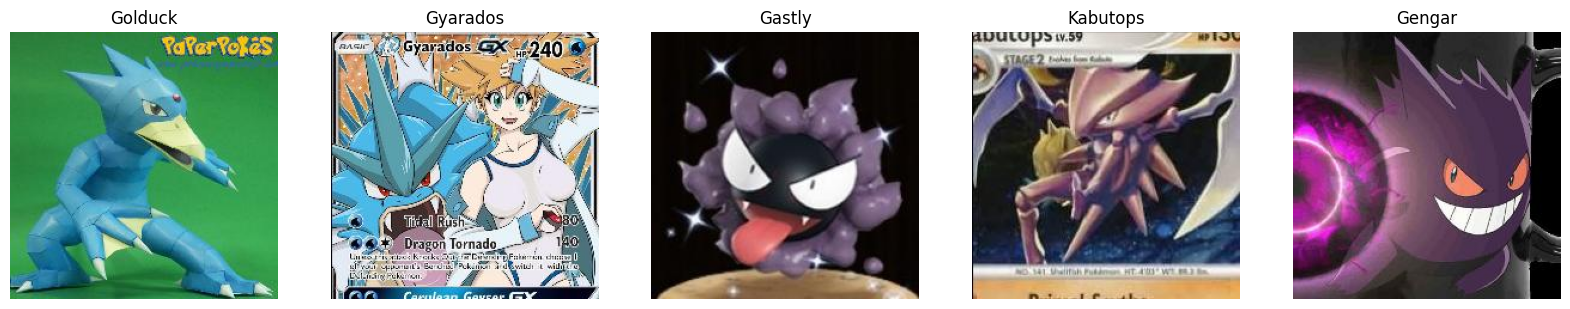

In [96]:
import matplotlib.pyplot as plt

sample_images = ds["train"]["image"][:5]
sample_labels = ds["train"]["labels"][:5]


fig, axes = plt.subplots(1, 5, figsize=(20, 20))
for i, (image, label) in enumerate(zip(sample_images, sample_labels)):
    axes[i].imshow(image)
    axes[i].set_title(pokemon_names[label])
    axes[i].axis("off")

plt.show()

### Train and Test Methods

In [97]:
from torch.utils.data import DataLoader
from torchvision import transforms

#Create pytorch dataset
class PokemonDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image = self.dataset[index]["image"]
        label = self.dataset[index]["labels"]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.dataset)
    

def pil_to_tensor(image):
    transform = transforms.ToTensor()
    return transform(image)


In [98]:

def train(model, loader, optimizer, criterion, num_epochs=10):
    loss_history = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for i, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            print(f"Epoch: {epoch} | Batch: {i} | Loss: {loss.item()}")
        loss_history.append(total_loss / len(loader))

    return loss_history


def test(model, loader, criterion):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss = 0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            loss = criterion(outputs, labels)
            correct += (predicted == labels).sum().item()

        print(f"Test accuracy: {correct / total}")
        return total_loss / len(loader), correct / total

  

## Train and Test the model



In [99]:
from datasets import Dataset
# Select only the first 12 labels
selected_labels = list(range(6))

# Filter the dataset to include only the selected labels
new_ds = ds['train'].filter(lambda example: example['labels'] in selected_labels)

train_ds = Dataset.from_dict({
    'image_file_path': new_ds['image_file_path'][:200],
    'image': new_ds['image'][:200],
    'labels': new_ds['labels'][:200]
})

test_ds = Dataset.from_dict({
    'image_file_path': new_ds['image_file_path'][200:],
    'image': new_ds['image'][200:],
    'labels': new_ds['labels'][200:]
})

# # Create datasets
train_dataset = PokemonDataset(train_ds, transform=pil_to_tensor)

test_dataset = PokemonDataset(test_ds, transform=pil_to_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

large_model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
num_features = large_model.classifier[-1].in_features
large_model.classifier[-1] = nn.Linear(num_features, len(selected_labels))
large_model = large_model.to(device)


Filter:   0%|          | 0/4869 [00:00<?, ? examples/s]

In [100]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(large_model.parameters(), lr=0.001)
loss_history = train(large_model, train_loader, optimizer, criterion, num_epochs=10)


Epoch: 0 | Batch: 0 | Loss: 1.7300410270690918
Epoch: 0 | Batch: 1 | Loss: 2.1007516384124756
Epoch: 0 | Batch: 2 | Loss: 1.6431167125701904
Epoch: 0 | Batch: 3 | Loss: 2.6426329612731934
Epoch: 0 | Batch: 4 | Loss: 2.4147181510925293
Epoch: 0 | Batch: 5 | Loss: 2.023914337158203
Epoch: 0 | Batch: 6 | Loss: 1.509876012802124
Epoch: 0 | Batch: 7 | Loss: 1.2980494499206543
Epoch: 0 | Batch: 8 | Loss: 1.738901972770691
Epoch: 0 | Batch: 9 | Loss: 1.9879652261734009
Epoch: 0 | Batch: 10 | Loss: 1.5952770709991455
Epoch: 0 | Batch: 11 | Loss: 2.1753768920898438
Epoch: 0 | Batch: 12 | Loss: 1.3784875869750977
Epoch: 0 | Batch: 13 | Loss: 0.9578273892402649
Epoch: 0 | Batch: 14 | Loss: 0.9168980717658997
Epoch: 0 | Batch: 15 | Loss: 1.819047212600708
Epoch: 0 | Batch: 16 | Loss: 1.0400279760360718
Epoch: 0 | Batch: 17 | Loss: 0.7506875991821289
Epoch: 0 | Batch: 18 | Loss: 1.125089406967163
Epoch: 0 | Batch: 19 | Loss: 1.040075659751892
Epoch: 0 | Batch: 20 | Loss: 1.0333597660064697
Epoch: 0

In [101]:
test_loss, test_acc = test(large_model, test_loader, criterion)
torch.save(large_model.state_dict(), "pokemon_model.pth")
print(test_loss, test_acc)

Test accuracy: 0.972972972972973
0.0 0.972972972972973


After training the model with only 200 images (6 classes)for 10 epochs, we get the test accuracy of about 97%.

The training time for 10 epochs was about 1 minute with pytorch mps backend (Apple M2 Pro). 

## Conclusion

We can see that the model performs well on the test set with 97% accuracy. This is a good result considering that we only used 200 images for training and the model was never trained on fictional characters like Pokemon.

Transfers learning on fictional characters classficiation like Pokemon works surprisingly well with really small amount of data and training time.